In [1]:
!pip install einops

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 1.7 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn as nn
from einops import rearrange, reduce, repeat
from typing import Optional, Tuple
from tqdm.notebook import tqdm
import math
import torch
import transformers
import torch.nn as nn
import torch.nn.functional as F
from torch.cuda.amp import GradScaler, autocast
from accelerate import Accelerator
from torch.utils.data import Dataset, DataLoader
import gc
import numpy as np

EPOCHS = 5
lr = 1e-4
SEED = 42
BATCH_SIZE = 64

In [3]:
class VitAbsoluteEncoding(nn.Module):
    """Construct the Absolute embeddings for vision model"""

    def __init__(self, config) -> None:
        super().__init__()
        image_height, image_width = config.image_size
        patch_height, patch_width = config.patch_size
        assert (
            image_height % patch_height == 0 and image_width % patch_width == 0
        ), "Image dimensions must be divisible by the patch size."

        num_patches = (image_height // patch_height) * (image_width // patch_width)
        patch_dim = config.num_channels * patch_height * patch_width
        self.pos_embeddings = nn.Parameter(torch.randn(1, num_patches + 1, patch_dim))
        self.register_buffer(
            "num_patches",
            torch.arange(num_patches + 1).expand((1, -1)),
            persistent=False,
        )

    def forward(self, img_seq: torch.Tensor) -> torch.Tensor:
        b, n, _ = img_seq.shape

        img_seq += self.pos_embeddings[:, : (n + 1)]
        return img_seq

In [4]:
_ACT_ = {
    "gelu": nn.GELU(),
    "leaky_relu": nn.LeakyReLU(),
    "relu6": nn.ReLU6(),
    "sigmoid": nn.Sigmoid(),
    "silu": nn.SiLU(),
    "swish": nn.SiLU(),
    "tanh": nn.Tanh(),
}

from typing import Optional, Tuple, Union


class FeedForward(nn.Module):
    def __init__(self, config, multiplier: Union[int, float] = 4) -> None:
        super().__init__()
        self.intermediate = nn.Linear(
            config.hidden_size, int(multiplier) * config.hidden_size
        )
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.layernorm = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps)
        if _ACT_.get(getattr(config, "hidden_act", None), None):
            self.act_fn = _ACT_[config.hidden_act]
        else:
            self.act_fn = nn.GELU()
        self.out = nn.Linear(int(multiplier) * config.hidden_size, config.hidden_size)

    def forward(
        self, hidden_state: torch.Tensor, input_tensor: torch.Tensor
    ) -> torch.Tensor:
        output = self.intermediate(hidden_state)
        output = self.act_fn(output)
        output = self.out(output)
        output = self.dropout(output)
        output = self.layernorm(output + input_tensor)
        return output

In [5]:
class AttentionSelfOutput(nn.Module):
    def __init__(
        self, config, bias: Optional[bool] = True, out_features: Optional[int] = None
    ):
        super().__init__()
        self.dense = nn.Linear(
            config.hidden_size,
            config.hidden_size if out_features is None else out_features,
            bias=bias,
        )
        self.layernorm = nn.LayerNorm(
            config.hidden_size, eps=getattr(config, "layer_norm_eps", 1e-6)
        )
        self.dropout = nn.Dropout(config.hidden_dropout_prob)

    def forward(
        self, hidden_states: torch.Tensor, input_tensor: torch.Tensor
    ) -> torch.Tensor:
        """
        Args:
            hidden_states: torch.FloatTensor of shape (batch, seq_len, embed_dim)`
            input_tensor: torch.FloatTensor of shape (batch, seq_len, embed_dim)`

        return:
               hidden_states: torch.FloatTensor of shape (batch, seq_len, embed_dim)

        """
        hidden_states = self.dense(hidden_states)
        hidden_states = self.dropout(hidden_states)
        hidden_states = self.layernorm(hidden_states + input_tensor)
        return hidden_states


class VisionAttention(nn.Module):
    def __init__(self, config, layer_idx: int) -> None:
        super().__init__()
        if config.hidden_size % config.num_attention_heads != 0:
            raise ValueError(
                f"The hidden size ({config.hidden_size}) is not a multiple of the number of attention "
                f"heads ({config.num_attention_heads})"
            )
        self.head_size = int(config.hidden_size // config.num_attention_heads)
        self.attention_bias = getattr(config, "attention_bias", True)
        self.layer_idx = layer_idx
        self.qkv = nn.Linear(config.hidden_size, 3 * config.hidden_size)
        self.out = AttentionSelfOutput(config=config, bias=self.attention_bias)
        self.num_attention_heads = config.num_attention_heads

    def forward(
        self,
        hidden_state: torch.Tensor,
        attention_mask: torch.Tensor,
        freqs: Optional[torch.Tensor] = None,
    ) -> torch.Tensor:
        """
        Args:
            hidden_states: torch.Tensor of shape (batch, seq_len, embed_dim)`
            attention_mask: torch.Tensor of shape (batch,1, seq_len, seqlen)`
            freqs: Positional freqs in case of RoPE embedding
        return:
               hidden_states: torch.Tensor of shape (batch, seq_len, embed_dim)

        """

        q, k, v = self.qkv(hidden_state).chunk(3, dim=-1)
        # transform it into batch_size x no_of_heads x seqlen x head_dim for Multihead Attention
        q = rearrange(q, "b l (h d) -> b h l d", h=self.num_attention_heads)
        k = rearrange(k, "b l (h d) -> b h l d", h=self.num_attention_heads)
        v = rearrange(v, "b l (h d) -> b h l d", h=self.num_attention_heads)
        if freqs is not None:
            q, k = apply_rotary_pos_emb(
                q,
                k,
                freqs,
            )  # apply RoPE if freqs is available

        out = torch.nn.functional.scaled_dot_product_attention(
            query=q, key=k, value=v, attn_mask=attention_mask, is_causal=False
        )
        # transform it back into batch_size x seqlen x hidden_dim
        out = rearrange(out, "b h l d -> b l (h d)")
        return self.out(out, hidden_state)

In [6]:
import torch
import torch.nn as nn
from typing import Optional, Tuple

from dataclasses import dataclass
from einops import rearrange, repeat


_position_embeddings = {
    "absolute": VitAbsoluteEncoding
    # "sinusoidal": SinusoidalEncoding,
}


@dataclass
class EncoderOutput(object):
    logits: torch.Tensor


@dataclass
class MLMOutput(object):
    hidden_state: torch.Tensor
    logits: torch.Tensor


class EncoderLayer(nn.Module):
    "encoder layer for encoder model"

    def __init__(
        self, config, layer_idx: int, attention_type: Optional[str] = None
    ) -> None:
        super().__init__()
        self.attention = VisionAttention(config, layer_idx=layer_idx)

        self.feed_forward = FeedForward(config)
        self.layer_idx = layer_idx

    def forward(
        self,
        hidden_state: torch.Tensor,
        attention_mask: torch.Tensor,
        freqs: Optional[torch.Tensor] = None,
    ) -> torch.Tensor:
        """
        Args:
            hidden_state: torch.Tensor of shape (batch, seq_len,embd_dim)
            attention_mask: torch.Tensor of shape (batch,1,1,seqlen)
            freqs: positionl information to use in RoPE
        return:
               hidden_state: torch.Tensor of shape (batch, seq_len, embed_dim) of last layer

        """
        out = self.attention(
            hidden_state=hidden_state, attention_mask=attention_mask, freqs=freqs
        )
        out = self.feed_forward(out, hidden_state)
        return out


class VisionModel(nn.Module):

    def __init__(
        self,
        config,
        pos_embedding_type: Optional[str] = "absolute",
    ) -> None:
        super().__init__()
        self.image_size = config.image_size
        self.patch_size = config.patch_size
        self.num_channels = config.num_channels
        self.num_patches = (self.image_size[0] // self.patch_size[0]) * (
            self.image_size[1] // self.patch_size[1]
        )
        if _position_embeddings.get(pos_embedding_type, None) is not None:
            self.position_embeddings = _position_embeddings.get(pos_embedding_type)(
                config
            )
        else:
            self.position_embeddings = None

        self.all_layer = nn.ModuleList(
            [
                EncoderLayer(config, layer_idx)
                for layer_idx in range(config.num_hidden_layers)
            ]
        )
        self.pixel_seq = nn.Conv2d(
            in_channels=self.num_channels,
            out_channels=config.hidden_size,
            kernel_size=self.patch_size,
            stride=self.patch_size,
        )
        patch_dim = config.num_channels * self.patch_size[0] * self.patch_size[1]
        self.cls_token = nn.Parameter(torch.randn(1, 1, patch_dim))

    def _init_weights(self, module: nn.Module) -> None:
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(
                module.weight, mean=0.0, std=0.02 / torch.sqrt(2 * len(self.all_layer))
            )
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(
                module.weight, mean=0.0, std=0.02 / torch.sqrt(2 * len(self.all_layer))
            )

    def forward(
        self, pixel_values: torch.Tensor, attention_mask: Optional[torch.Tensor] = None
    ) -> torch.Tensor:
        """
        Args:
            input_ids: torch.LongTensor of shape (batch, seq_len) for encoder`
            attention_mask: torch.Tensor of shape (batch,seqlen) for encoder
        return:
               logits: torch.Tensor of shape (batch, seq_len, embed_dim) of last layer

        """

        img_seq = self.pixel_seq(pixel_values)
        hidden_state = rearrange(img_seq, "b d c1 c2 -> b (c1 c2) d")
        bsz, seqlen, _ = hidden_state.shape

        # rearrange(image, "b c (h p1) (w p2) -> b (h w) (c p1 p2)", p1=p1, p2=p2)
        cls_tokens = repeat(self.cls_token, "1 1 d -> b 1 d", b=bsz).to(
            hidden_state.device
        )
        hidden_state = torch.cat((cls_tokens, hidden_state), dim=1)

        freqs = None
        if self.position_embeddings is not None:
            pos_info = self.position_embeddings(hidden_state)
            hidden_state = hidden_state + pos_info
        else:
            freqs = self.emb_freq[:, :seqlen].to(pixel_values.device)

        if attention_mask is None:
            encoder_batch_size, encoder_sequence_length, _ = hidden_state.size()
            encoder_hidden_shape = (encoder_batch_size, encoder_sequence_length)
            attention_mask = torch.ones(
                encoder_hidden_shape, device=pixel_values.device
            )

        attention_mask = attention_mask.unsqueeze(1).unsqueeze(2).type_as(hidden_state)
        attention_mask = (1.0 - attention_mask) * torch.finfo(
            hidden_state.dtype
        ).min  # invert it to to add directly to attention score

        for layer in self.all_layer:
            hidden_state = layer(hidden_state, attention_mask, freqs)
        return EncoderOutput(hidden_state)

    @classmethod
    def from_config(
        cls,
        config,
        pos_embedding_type: Optional[str] = "absolute",
    ) -> nn.Module:
        return cls(config, pos_embedding_type)

In [7]:
@dataclass
class Config:
    hidden_size: int = 768
    num_attention_heads: int = 12
    image_size: Tuple[int] = (224, 224)
    patch_size: Tuple[int] = (16, 16)
    num_channels: int = 3
    num_hidden_layers: int = 8
    hidden_dropout_prob: float = 0.1
    initializer_range: float = 0.02
    intermediate_size: int = 3072
    layer_norm_eps: float = 1e-05
    hidden_act: str = "gelu"

In [8]:
config = Config()
vit = VisionModel(config)

In [9]:
image = torch.rand((4, 3, 224, 224))
vit(image).logits.size()

torch.Size([4, 197, 768])

In [10]:
from torch.utils.data import Dataset, random_split, DataLoader
from PIL import Image
import torchvision.transforms as T


class MyDataset(Dataset):
    def __init__(self, root_dir, df, transform=None):
        self.transform = transform
        self.root_dir = root_dir
        self.image_path = df["image_name"].values
        self.label = df["label"].values

    def __len__(self):
        return len(self.label)

    def __getitem__(self, idx):
        img_path = self.image_path[idx]
        img = Image.open(self.root_dir + "/" + img_path)

        if self.transform:
            img = self.transform(img)

        return img, self.label[idx]


imagenet_stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

In [11]:
import pandas as pd

df = pd.read_csv("../input/scene-classification/train-scene classification/train.csv")

In [12]:
df.head()

,image_name,label
0,0.jpg,0
1,1.jpg,4
2,2.jpg,5
3,4.jpg,0
4,7.jpg,4


In [13]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.2)

In [14]:
imagenet_stats = (
    [0.485, 0.456, 0.406],
    [0.229, 0.224, 0.225],
)  # mean and std values of the Imagenet Dataset so that pretrained models could also be used

# setting a set of transformations to transform the images
transform = T.Compose(
    [
        T.Resize((224, 224)),
        T.RandomHorizontalFlip(),
        T.RandomRotation(2),
        T.ToTensor(),
        T.Normalize(*imagenet_stats),
    ]
)
test_transform = T.Compose(
    [T.Resize((224, 224)), T.ToTensor(), T.Normalize(*imagenet_stats)]
)

In [15]:
data_dir = "../input/scene-classification/train-scene classification/train"
train_loader = DataLoader(
    MyDataset(data_dir, train, transform=transform),
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
)
val_loader = DataLoader(
    MyDataset(data_dir, test, transform=test_transform),
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
)

In [16]:
df["label"].nunique()

6

In [17]:
class VitModel(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.output = nn.Linear(768, 6)

    def forward(self, ids):
        sequence_output = self.model(ids).logits[:, 0, :]  # taking cls token info
        logits = self.output(sequence_output)
        return logits

In [18]:
def valid_func(model, val_loader, val_bar):
    model.eval()
    loss_fn = torch.nn.CrossEntropyLoss()
    PROB = []
    TARGETS = []
    losses = []
    PREDS = []

    for batch_idx, data in enumerate(val_loader):
        val_bar.update(1)
        pixel_values = data[0].cuda()
        targets = data[1].long().view(-1).cuda()
        with torch.no_grad():
            logits = model(pixel_values)

        PREDS += [torch.argmax(logits, 1).detach().cpu()]
        TARGETS += [targets.detach().cpu()]

        loss = loss_fn(logits, targets)
        losses.append(loss.item())
        val_bar.set_description(f'step: {batch_idx+1} loss: {"%.4f" % loss}')

    PREDS = torch.cat(PREDS).cpu().numpy()
    TARGETS = torch.cat(TARGETS).cpu().numpy()
    accuracy = (PREDS == TARGETS).mean()

    loss_valid = np.mean(losses)
    return loss_valid, accuracy

In [19]:
from transformers import get_linear_schedule_with_warmup


def single_gpu(name):
    use_amp = True
    debug = False
    gc.collect()
    best_epoch_loss = np.inf

    net = VitModel(vit)
    net.cuda()

    accelerator = Accelerator(log_with="tensorboard", project_dir=".")
    Config = {
        "num_epoch": EPOCHS,
        "learning_rate": lr,
        "loss_function": str(torch.nn.CrossEntropyLoss),
    }

    accelerator.init_trackers(f"{name}_project", config=Config)
    accumulation_steps = 2
    loss_fn = torch.nn.CrossEntropyLoss()
    no_decay = ["bias", "layernorm.weight", "layernorm.bias"]
    optimizer_grouped_parameters = [
        {
            "params": [
                p
                for n, p in net.named_parameters()
                if not any(nd in n for nd in no_decay)
            ],
            "weight_decay": 0.01,
        },
        {
            "params": [
                p for n, p in net.named_parameters() if any(nd in n for nd in no_decay)
            ],
            "weight_decay": 0.0,
        },
    ]
    optimizer = torch.optim.AdamW(optimizer_grouped_parameters, lr=lr)

    num_train_optimization_steps = int(EPOCHS * len(train_loader) / accumulation_steps)

    lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", patience=1, factor=0.8
    )

    epoch_check = len(train_loader)
    total_step = epoch_check * EPOCHS
    train_bar = tqdm(total=total_step, dynamic_ncols=True)
    val_bar = tqdm(total=len(val_loader), leave=True, dynamic_ncols=True)
    t_step = 1
    for epoch in range(EPOCHS):
        avg_loss = 0.0
        net.train()
        loss_list = []
        for step, data in enumerate(train_loader):
            train_bar.update(1)
            optimizer.zero_grad()
            pixel_values = data[0].cuda()

            targets = data[1].long().view(-1).cuda()

            pred = net(pixel_values)
            loss = loss_fn(pred, targets)
            loss.backward()
            optimizer.step()

            accelerator.log({"training_loss_step": loss}, step=t_step)
            t_step += 1

            loss_list.append(loss.detach().cpu().item())
        avg_loss = np.round(np.mean(loss_list), 4)
        accelerator.log({"train_epoch": avg_loss}, step=epoch)
        print(f'train_epoch-{epoch} loss: {"%.4f" % avg_loss}')
        vloss, vaccuracy = valid_func(net, val_loader, val_bar)
        accelerator.log({"vloss_epoch": loss}, step=epoch)
        accelerator.log({"vaccuracy_epoch": vaccuracy}, step=epoch)
        print(f'Epoc: {epoch} loss: {"%.4f" % vloss},accuracy: {"%.4f" % vaccuracy}')
        val_bar.reset()
        lr_scheduler.step(vloss)
    accelerator.end_training()

In [20]:
single_gpu(name="vit_classification")

2024-05-21 17:56:54.476303: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-21 17:56:54.476454: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-21 17:56:54.608051: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


  0%|          | 0/1065 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

train_epoch-0 loss: 1.2323
Epoc: 0 loss: 0.9129,accuracy: 0.6490
train_epoch-1 loss: 0.8301
Epoc: 1 loss: 0.8020,accuracy: 0.6854
train_epoch-2 loss: 0.6951
Epoc: 2 loss: 0.6591,accuracy: 0.7508
train_epoch-3 loss: 0.6389
Epoc: 3 loss: 0.6812,accuracy: 0.7488
train_epoch-4 loss: 0.5732
Epoc: 4 loss: 0.6129,accuracy: 0.7696


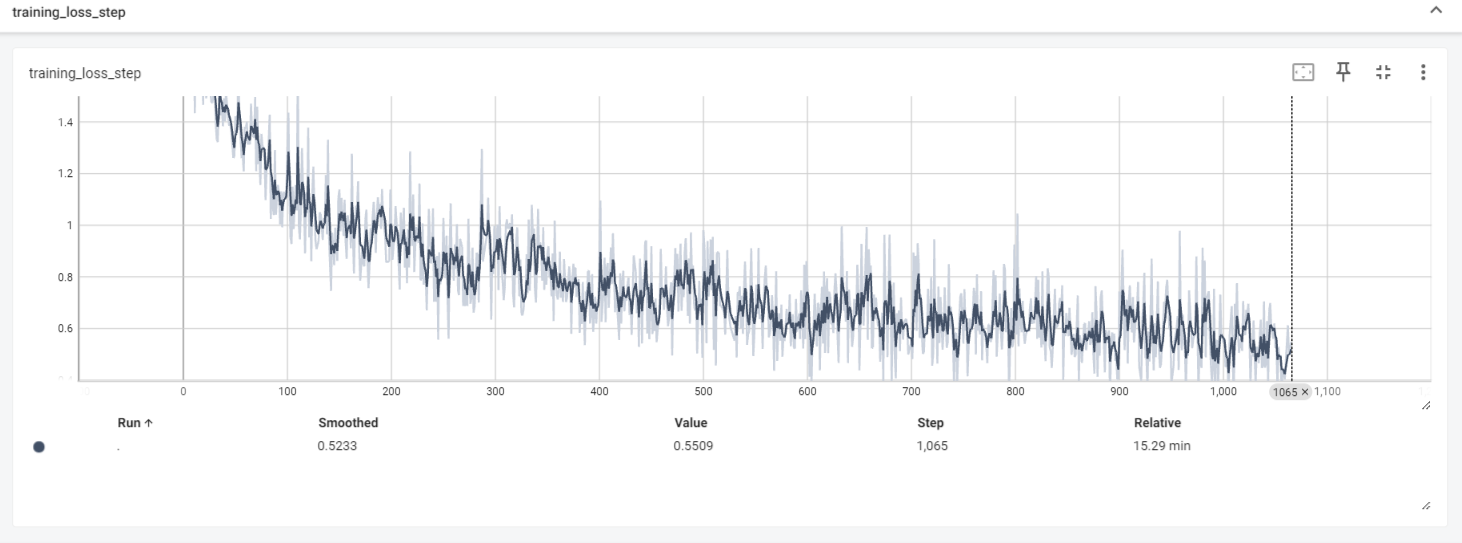

**Next Step**


*extend it to use 2D Absolute  and 2D Rope embeding*